In [2]:
import numpy as np
import scipy as sp
from astropy.io import fits as pyfits
from astropy.table import Table
import desispec.io
from desispec.interpolation import resample_flux
#from desitarget.targetmask import desi_mask
#import sys
import os
from multiprocessing import Pool

import scipy.optimize as scpo
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import iminuit

import fitsio

# Desi catalog test
import glob
from itertools import compress
import healpy

#import empca
import time

print('Loading done')

Loading done


In [22]:
def writeDelta( path_out, QSOlist, nside_ = 8, nest_ = False ):
# save output
   
   ra  = np.array( [ QSOlist[i].ra  for i in range( len(QSOlist) ) ]  )
   dec = np.array( [ QSOlist[i].dec for i in range( len(QSOlist) ) ]  )
   
   pix = healpy.ang2pix( nside_ , sp.pi/2.-dec, ra, nest=nest_ )

   tags = np.unique(pix)

   print('Writting data from '+ str(len(QSOlist))+' QSOs.')

   for j in range(0, len(tags) ):   #  len(tags)
      out = fitsio.FITS(path_out+'/delta-'+ str(tags[j]) +'.fits.gz','rw',clobber=True)
      mask = pix == int( tags[j])
      are  =  np.squeeze( np.where(mask) )
      print( mask, np.squeeze( np.where(mask) ) )
    
     try:
        iter(are)
     except TypeError:
        are = [are]


      for i in are:
         print(i,'     ')
         hd = [ {'name':'RA','value':QSOlist[ i ].ra,'comment':'Right Ascension [rad]'},
                 {'name':'DEC','value':QSOlist[ i ].dec,'comment':'Declination [rad]'},
                 {'name':'Z','value':QSOlist[ i ].z,'comment':'Redshift'},
                 {'name':'PMF','value':'{}-{}-{}'.format(1,1,1)},
                 {'name':'THING_ID','value':QSOlist[ i ].thingid,'comment':'Object identification'},
                 {'name':'PLATE','value':tags[j]},
                 {'name':'MJD','value':1,'comment':'Modified Julian date'},
                 {'name':'FIBERID','value':QSOlist[ i ].thingid},
                 {'name':'ORDER','value':1,'comment':'Order of the continuum fit'},
         ]

         cols=[np.log10( QSOlist[i].delta.w ), QSOlist[i].delta.delta, QSOlist[i].delta.ivar, QSOlist[i].delta.cont    ]    

         names=['LOGLAM','DELTA','WEIGHT','CONT']
         units=['Log Angstrom','','','']
         comments = ['Log Lambda','Delta field','Pixel weights','Continuum']

         out.write(cols,names=names,header=hd,comment=comments,units=units,extname=str(QSOlist[ i ].thingid) )

      out.close()
      print('Done writting to file '+str(tags[j])+'.' )
   print('All files written.')
            
path_out = '/global/homes/s/sfbeltr/respaldo/out_deltas/lyadeltas-desi-Y1/deltas'

#writeDelta(path_out, QSOloc_eBoss, spectra_eBoss, 'eBoss')
writeDelta( path_out, QSOlist_parallel )

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 19)

In [3]:
class DELTA():
   def __init__(self, w, delta, ivar, cont ):
      self.w = w
      self.delta = delta
      self.ivar = ivar     # ivar weight with var correction
      self.cont = cont

class QSO:
   @classmethod
   def get_mcont(cls, w):
      raise NotImplementedError("Function should be specified at run-time")
   @classmethod
   def get_eta(cls, w):
      raise NotImplementedError("Function should be specified at run-time")      
   @classmethod
   def get_sigma(cls, w):
      raise NotImplementedError("Function should be specified at run-time")
   @classmethod
   def get_epsilon(cls, w):
      raise NotImplementedError("Function should be specified at run-time")
   
   def __init__(self, w, flux, ivar, z, ra, dec, thingid, fiberid, mjd):
      self.w = w
      self.flux = flux
      self.ivar = ivar    # for pipeline ivar
      self.z = z
      self.ra = ra
      self.dec = dec
      self.thingid = thingid
      self.fiberid = fiberid
      self.mjd = mjd
      
      self.delta = DELTA( w *( 1 + z ), flux, ivar, flux)
      
def normalizeSpec( x, y, xmin, xmax):
   normfactor = xmax-xmin
   xrange =  (x > xmin ) & (x < xmax ) 
   
   return y / ( np.sum(y[xrange]) * (x[1]-x[0]) ) * normfactor

def splitID(fi_str):
   fi_str= fi_str.split("spectra-16-")[1]
   return fi_str.split(".fits")[0]


In [4]:

# Multiprocessing test
def load_pix( file ):
   
   global targetid
   global zqso
   global DEC
   global RA
   global heal_pix
   global lminrest
   global lmaxrest

   thisplate = splitID(file)
   
   wp = heal_pix == int( thisplate )

   ids_ = targetid[wp]
   zqso_= zqso[wp]
   DEC_ = DEC[wp]
   RA_ = RA[wp]
   heal_pix_ = heal_pix[wp]
   
   nqsoPlate_= ids_.shape[0]
      
   spectra_base = desispec.io.read_spectra( file )   
   
   joint1 = np.in1d( spectra_base.wave['b'], spectra_base.wave['r'])
   joint2 = np.in1d( spectra_base.wave['r'], spectra_base.wave['b'])
   
   ll = np.concatenate( ( spectra_base.wave['b'][np.invert(joint1)] , spectra_base.wave['r'] ) )
   
   data = []
      
   for i in range( 0, nqsoPlate_):   #nqsoPlate_

      index = np.where( np.array( spectra_base.fibermap['TARGETID'].data ) == ids_.data[i] )
      index = np.squeeze(index)

      w_ = (ll)/(1+zqso_[ i ])
      w_crop = ( w_ >= lminrest ) & ( w_ <= lmaxrest )
      w_ = w_[w_crop] 

      intersec = ( spectra_base.ivar['b'][ index ][joint1]*spectra_base.flux['b'][ index ][joint1] + spectra_base.ivar['r'][ index ][joint2]*spectra_base.flux['r'][ index ][joint2] )
      intersec = intersec /( spectra_base.ivar['b'][ index ][joint1] + spectra_base.ivar['r'][ index ][joint2] )

      flx = np.concatenate( ( spectra_base.flux['b'][ index ][np.invert(joint1)], intersec, \
            spectra_base.flux['r'][ index ][np.invert(joint2)] ) )
      flx = flx[w_crop]

      intersec = ( spectra_base.ivar['b'][ index ][joint1] + spectra_base.ivar['r'][ index ][joint2] ) 
      ivr = np.concatenate( ( spectra_base.ivar['b'][ index ][np.invert(joint1)], intersec, \
            spectra_base.ivar['r'][ index ][np.invert(joint2)] ) )
      ivr = ivr[w_crop]

      flx = normalizeSpec( w_, flx, 1300, 1500)
      #flx = normalizeSpec( w_, flx, 1300, 1500)

      w_crop = ( w_ >= 1040 ) & ( w_ <= 1200 ) & (ivr> 0 )
      w_ = w_[w_crop]
      flx = flx[w_crop]
      ivr = ivr[w_crop]

      data.append( QSO( w_, flx, ivr, zqso_[i], RA_[i],  DEC_[i], ids_[i], ids_[i], 1 ) )
   
   #print( file, ': ', ids_.shape[0], len(data) )
   return data


def load_Desi_parallel(path_zcat, path_spec, zmin, zmax, lmin, lmax, multiC = 2, nspec = 150):
   # Desi Catalog load, beginning of function
   catalog = Table.read(path_zcat)
   qso_string = catalog['SPECTYPE'][0]

   w = (catalog['SPECTYPE']==qso_string ) & (catalog['Z'] >= zmin ) & (catalog['Z'] <= zmax ) 
   reduced_cat = catalog[w]

   if ( nspec > 1 and nspec < len(reduced_cat) ):
      print("Reducing catalog to "+str(nspec)+" spectra.")
      w = np.random.choice( len(reduced_cat), nspec, replace=False)
      reduced_cat = reduced_cat[w]
    
   nest = True
   in_nside = 16
   
   global targetid
   global zqso
   global DEC
   global RA
   global heal_pix
   global lminrest
   global lmaxrest
   
   lminrest = lmin
   lmaxrest = lmax
   
   targetid = reduced_cat['TARGETID']
   zqso = reduced_cat['Z']
   DEC = reduced_cat['DEC'] * np.pi/180
   RA = reduced_cat['RA'] * np.pi/180
   #LATE = reduced_cat['TILEID']
   
   heal_pix = healpy.ang2pix(in_nside, sp.pi/2.-DEC, RA, nest)
   plate_list = np.unique(heal_pix)
   
   #print('healpix len: ', len(plate_list), 'healpix values: ',  plate_list )
   fi = glob.glob(path_spec+'/*/*/spectra*.fits*')
   print('Found', len(fi), 'spectra files.\n')
   
   fi_fix = []
   for i in range( 0, len(fi) ):
       fi_fix.append( splitID(fi[i]) )

   fi_fix =  np.array( list(map(int, fi_fix)) ) 
   
   print('Found '+ str(  np.sum(w) ) + ' QSO spec. in ' + str( len(plate_list) ) + ' files.' )

                            # from healpix.  #found files
   wpf_ = np.where( np.in1d(   plate_list,   fi_fix) )[0]
        # to crop catalog files to N: wpf_[0:N]
   
   fi_load = [ fi[index] for index in wpf_ ] 

   pool = Pool( processes = multiC )   
   data_pix = pool.map( load_pix , fi_load)
   pool.close()
   
   QSOlist = []

   for i in range( len (data_pix ) ):
      QSOlist.extend( data_pix[i] )
   
   del data_pix
   return QSOlist

path_zcat = '/global/cfs/projectdirs/desi/mocks/lya_forest/develop/london/qq_desi/v9.0_Y1/v9.0.0/desiY1-0.0/zcat.fits' 
path_spec = '/global/cfs/projectdirs/desi/mocks/lya_forest/develop/london/qq_desi/v9.0_Y1/v9.0.0/desiY1-0.0/spectra-16'

zmin = 2.
zmax = 4.288461538461538

lmin = 1040
lmax = 1600

start   = time.time()
QSOlist_parallel = load_Desi_parallel(path_zcat, path_spec, zmin, zmax, lmin, lmax)
end   = time.time()
print(len(QSOlist_parallel),' QSO in ', end-start,' seconds.')

Reducing catalog to 150 spectra.
Found 613 spectra files.

Found 24862899 QSO spec. in 126 files.
INFO:spectra.py:282:read_spectra: iotime 0.423 sec to read spectra-16-777.fits at 2021-09-17T06:26:57.094998
INFO:spectra.py:282:read_spectra: iotime 1.307 sec to read spectra-16-672.fits at 2021-09-17T06:26:57.979065
INFO:spectra.py:282:read_spectra: iotime 1.040 sec to read spectra-16-773.fits at 2021-09-17T06:26:58.341102
INFO:spectra.py:282:read_spectra: iotime 0.394 sec to read spectra-16-786.fits at 2021-09-17T06:26:59.372175
INFO:spectra.py:282:read_spectra: iotime 1.151 sec to read spectra-16-660.fits at 2021-09-17T06:26:59.941615
INFO:spectra.py:282:read_spectra: iotime 1.139 sec to read spectra-16-774.fits at 2021-09-17T06:27:00.706833
INFO:spectra.py:282:read_spectra: iotime 0.130 sec to read spectra-16-617.fits at 2021-09-17T06:27:00.710180
INFO:spectra.py:282:read_spectra: iotime 0.889 sec to read spectra-16-659.fits at 2021-09-17T06:27:01.626103
INFO:spectra.py:282:read_spect

In [218]:
def load_piccaDelta(file):
   catalog = pyfits.open( file ) 
   QSOlist = []
   for j in range(1, len(catalog) ):
      qso = QSO( 10**catalog[j].data['LOGLAM'] / (1 + catalog[j].header['Z'] ), (catalog[j].data['DELTA']+1)*catalog[j].data['CONT'], catalog[j].data['WEIGHT'], catalog[j].header['Z'], catalog[j].header['RA'],  catalog[j].header['DEC'], catalog[j].header['THING_ID'], catalog[j].header['THING_ID'], 1 )     
      qso.delta.cont = catalog[j].data['CONT']
      QSOlist.append( qso )

   return QSOlist


def load_Picca(dir):

   ################# delta reading and loading with thing_id
   
   '''
   dir  = '/work/sfbeltranv/output/deltas'

   catalog = pyfits.open(dir + 'delta-100.fits.gz')

   catalog[1].header

   plt.plot( catalog[1].data['LOGLAM'], catalog[1].data['DELTA'] )

   catalog[1].header
   catalog[1].header['THING_ID']
   '''

   ################## script to load al delta-healpix piles


   fi = glob.glob(dir+'/*')
   print( 'Loading from ', len(fi), ' delta files.' )
   QSOlist = []
   
   pool = Pool( processes = 20 )
   data_pix = pool.map( load_piccaDelta , fi)
   pool.close()
   
   for i in range( len (data_pix ) ):
      QSOlist.extend( data_pix[i] )
   
   del data_pix
   print('Loaded', len(QSOlist), 'QSO.')
   return QSOlist

dir  = '/work/sfbeltranv/output/deltas'
QSOlist_Picca = load_Picca(dir)


Loading from  45  delta files.
Loaded 6408 QSO.


In [219]:
# Multi blinding + variance correction
# load var stats calc with picca

dir1 = '/work/sfbeltranv/output/log/delta_attributes.fits.gz'

cfit1 = pyfits.open( dir1 ,  mode='readonly')     # mode: 'readonly' or 'update'

QSOlist = QSOlist_Picca

w = 10**cfit1[2].data['loglam']

global stack
stack = interp1d( 10**cfit1[1].data['loglam'], cfit1[1].data['stack'], fill_value="extrapolate")     
QSO.get_mcont   = interp1d( 10**cfit1[3].data['loglam_rest'], cfit1[3].data['mean_cont'], fill_value="extrapolate")     
QSO.get_eta     = interp1d( 10**cfit1[2].data['loglam'], cfit1[2].data['eta'], fill_value="extrapolate" )  
QSO.get_sigma   = interp1d( 10**cfit1[2].data['loglam'], cfit1[2].data['var_lss'], fill_value="extrapolate" )  
QSO.get_epsilon = interp1d( 10**cfit1[2].data['loglam'], cfit1[2].data['fudge'], fill_value="extrapolate" )  

cfit1.close()

def blindQSO(qso):
   global lol_, l_, Zmz_, Z_, stack

   #print('\t\t QSO ', j, ' of ', len(catalog), '.' )
   # Z QSO ap shift
   Za = qso.z
   Z_rebin = np.interp( Za, Z_, Zmz_ )
   qso.z = Za + Z_rebin

   # QSO forest ap shift with interval conservation
   l = qso.w * (1 + Za)
   lol_rebin = resample_flux( l, l_, lol_ )

   flux = ( qso.flux  ) * qso.get_mcont( qso.w ) *  stack( l )
   
   #dx = (l[1]-l[0])
   #f = ( lol_rebin - 1 )
   #A = np.sum(f)*dx
   #lol_rebin = ( lol_rebin - 1 ) - A/(dx*len(f)) + 1

   l_rebin = lol_rebin*l
   #l_rebin = l_rebin - l_rebin[int(len(l_rebin)/2)] + l[int(len(l)/2)]
   
   llog = np.log10(l)
   #l2 = l-( l[0]-l_rebin[0] )
   l2 = 10**(  np.arange( np.log10( np.min(l_rebin) ), np.log10( np.max(l_rebin) ), llog[1]-llog[0] )    )
   
   flux, ivar = resample_flux( l2, l_rebin, flux, ivar=qso.ivar )
   delta, ivar2 = resample_flux( l2, l_rebin, qso.delta.delta, ivar=qso.delta.ivar )
   cont = resample_flux( l2, l_rebin, qso.delta.cont  )

   qso.w = l2 / (1 + qso.z)
   qso.delta.w = l2
   
   qso.flux =  flux 
   qso.ivar =  ivar
   
   qso.delta.delta = delta
   qso.delta.ivar = ivar2
   
   qso.delta.cont = cont

   return qso

def blindDeltas( QSOlist, multi = 60):
   global lol_, l_, Zmz_, Z_
   
   lol_ = np.load('/work/sfbeltranv/lya-blinding/lol.npy')
   l_ = np.load('/work/sfbeltranv/lya-blinding/l.npy')
   
   Zmz_ = np.load('/work/sfbeltranv/lya-blinding/zmz.npy')
   Z_ = np.load('/work/sfbeltranv/lya-blinding/z.npy')
   
   pool = Pool( processes = multi)   
   QSOlist = pool.map( blindQSO, QSOlist )
   pool.close()
   
   print("Deltas blinded.")
   return QSOlist
   
QSOlist = blindDeltas( QSOlist_Picca )



Deltas blinded.


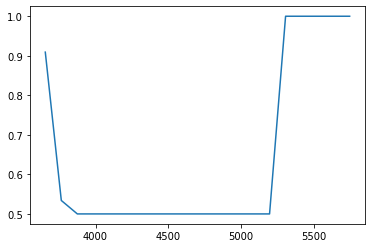

In [236]:
'''plt.plot( QSOlist_Picca[i].delta.w,  QSOlist_Picca[i].delta.delta, 'b')
plt.plot( QSOlist[i].delta.w,  QSOlist[i].delta.delta, 'r' )'''



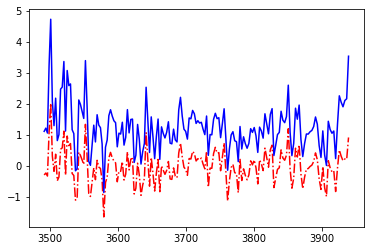

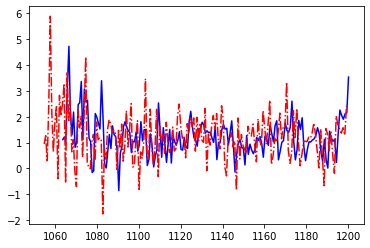

In [232]:
i = 4

#plt.plot(QSOlist[i].delta.w, QSOlist[i].delta.delta, 'b' )
plt.plot(QSOlist[i].delta.w, QSOlist[i].delta.delta, 'r-.' )
plt.plot(QSOlist[i].w*(1+QSOlist[i].z), QSOlist[i].flux, 'b' )

plt.show()

plt.plot(QSOlist[i].w, QSOlist[i].flux, 'b' )
plt.plot(QSOlist_Picca[i].w, QSOlist_Picca[i].flux, 'r-.' )
plt.show()

In [229]:

# Calculation of MeanContinuum
def calcMeanCont(QSOlist, mean = 0, lmin = 1040, lmax=1200):
   dll = 1
   
   nstack = int((lmax - lmin)/dll)+1
   ll = lmin + ( np.arange(nstack)+0.5 ) * dll
   mcont = np.zeros(nstack)
   wcont = np.zeros(nstack)
   
   
   for i in range( len(QSOlist) ):   # len(deltas)
      wave = QSOlist[i].w
      bins = ( (wave - lmin) / dll + 0.5 ).astype(int)
      
      varpipe = 1 / ( QSOlist[i].ivar*QSOlist[i].delta.cont )
      var = QSOlist[i].get_eta(wave)*varpipe + QSOlist[i].get_sigma(wave) + QSOlist[i].get_epsilon(wave)/varpipe
      weight = 1 / var
      
      c = np.bincount( bins, weights = QSOlist[i].flux / QSOlist[i].delta.cont*weight )
      mcont[:len(c)]+=c 
      c = np.bincount( bins, weights = weight )
      wcont[:len(c)]+=c
   w = wcont > 0
   mcont[w] /= wcont[w]
   mcont /= mcont.mean()
   wcont /= wcont[w].mean()
   #plt.plot(ll,mcont)
   #plt.plot(ll,wcont)
   #plt.show()
   return ll, mcont, wcont

def chi2cont( alpha, *args ):
   a,b = alpha
   w, flux, ivar, mcont, eta, sigma, epsilon = args
   newc = (a*w+b) * mcont
   varpipe = 1 / ivar / newc**2
   variance = eta*varpipe + sigma + epsilon/varpipe
   weight = 1 / newc**2 / variance
   chi2_contribution = (flux - newc)**2 * weight
   return chi2_contribution.sum() - np.log(weight).sum()



def minimizeVariances(QSOlist, lmin=3600, lmax=5800, lrmin=1040, lrmax=1200, num_bins = 20, limit_eta=(0.5, 1.5), limit_var_lss=(0., 0.3)):       
   # Bins for final correction saved in bins with groups of wavelenghts
   get_mcont = QSO.get_mcont
   
   eta = np.zeros(num_bins)
   var_lss = np.zeros(num_bins)
   epsilon = np.zeros(num_bins)
   error_eta = np.zeros(num_bins)
   error_var_lss = np.zeros(num_bins)
   error_epsilon = np.zeros(num_bins)
   num_pixels = np.zeros(num_bins)
   ll = (lmin + (np.arange(num_bins) + .5) *
                  (lmax - lmin) / num_bins)
   # Value list for pipeline correction
   num_var_bins = 100
   var_pipe_min = np.log10(1e-5)
   var_pipe_max = np.log10(20)
   var_pipe_values = 10**(var_pipe_min +
                           ((np.arange(num_var_bins) + .5) *
                            (var_pipe_max - var_pipe_min) / num_var_bins))
   
   var_delta = np.zeros(num_bins * num_var_bins)
   mean_delta = np.zeros(num_bins * num_var_bins)
   var2_delta = np.zeros(num_bins * num_var_bins)
   count = np.zeros(num_bins * num_var_bins)
   num_qso = np.zeros(num_bins * num_var_bins)
   print('Binning deltas')
   for i in range( len(QSOlist) ):   # len(deltas)
      # print('delta '+str(i)+' of '+str( len(deltas) )+'.' )
      # wave, delta, ivar, flx, CF
      wave = QSOlist[i].delta.w
      
      var_pipe =  1 / ( QSOlist[i].ivar * (QSOlist[i].delta.cont)**2 )
      w = ((np.log10(var_pipe) > var_pipe_min) &
                 (np.log10(var_pipe) < var_pipe_max))
      log_lambda_bins = ((wave  - lmin) /
                               (lmax - lmin) * num_bins).astype(int)
      var_pipe_bins = np.floor(
                (np.log10(var_pipe) - var_pipe_min) /
                (var_pipe_max - var_pipe_min) * num_var_bins).astype(int)
      log_lambda_bins = log_lambda_bins[w]
      var_pipe_bins = var_pipe_bins[w]
      bins = var_pipe_bins + num_var_bins * log_lambda_bins
      # compute deltas
      delta = QSOlist[i].delta.delta
      delta = delta[w]
      
      # add contributions to delta statistics
      rebin = np.bincount(bins, weights=delta)
      mean_delta[:len(rebin)] += rebin

      rebin = np.bincount(bins, weights=delta**2)
      var_delta[:len(rebin)] += rebin

      rebin = np.bincount(bins, weights=delta**4)
      var2_delta[:len(rebin)] += rebin

      rebin = np.bincount(bins)
      count[:len(rebin)] += rebin
      num_qso[np.unique(bins)] += 1
   
   w = count > 0
   var_delta[w] /= count[w]
   mean_delta[w] /= count[w]
   var_delta -= mean_delta**2
   var2_delta[w] /= count[w]
   var2_delta -= var_delta**2
   var2_delta[w] /= count[w]
   # fit the functions eta, var_lss, and fudge
   chi2_in_bin = np.zeros(num_bins)
   epsilon_ref = 1e-7
   print('Deltas calculated, minimizing var bins in lambda')
   for index in range(num_bins):
      #print('Bin '+str(index)+' of '+str(num_bins)+'.' )
      # pylint: disable-msg=cell-var-from-loop
      # this function is defined differntly at each step of the loop
      def chi2varfit(eta, var_lss, epsilon):
         variance = eta * var_pipe_values + var_lss + epsilon*epsilon_ref / var_pipe_values
         chi2_contribution = (var_delta[index * num_var_bins:(index + 1) * num_var_bins] - variance)
         weights = var2_delta[index * num_var_bins:(index + 1) * num_var_bins]
         w = num_qso[index * num_var_bins:(index + 1) * num_var_bins] > 100
         return np.sum(chi2_contribution[w]**2 / weights[w])
      minimizer = iminuit.Minuit(chi2varfit,
                       name=("eta", "var_lss", "epsilon"),
                       eta=1.,
                       var_lss=0.1,
                       epsilon=1.,
                       error_eta=0.05,
                       error_var_lss=0.05,
                       error_epsilon=0.05,
                       errordef=1.,
                       print_level=0,
                       limit_eta=limit_eta,
                       limit_var_lss=limit_var_lss,
                       limit_epsilon=(0, None))
      minimizer.migrad()
      if minimizer.migrad_ok():
         minimizer.hesse()
         eta[index] = minimizer.values["eta"]
         var_lss[index] = minimizer.values["var_lss"]
         epsilon[index] = minimizer.values["epsilon"] * epsilon_ref
         error_eta[index] = minimizer.errors["eta"]
         error_var_lss[index] = minimizer.errors["var_lss"]
         error_epsilon[index] = minimizer.errors["epsilon"] * epsilon_ref
      else:
         eta[index] = 1.
         var_lss[index] = 0.1
         epsilon[index] = 1. * epsilon_ref
         error_eta[index] = 0.
         error_var_lss[index] = 0.
         error_epsilon[index] = 0.
      num_pixels[index] = count[index * num_var_bins:(index + 1) *
                         num_var_bins].sum()
      chi2_in_bin[index] = minimizer.fval
   print('Done iterating')   
   return (ll, eta, var_lss, epsilon, num_pixels, var_pipe_values,
            var_delta.reshape(num_bins, -1), var2_delta.reshape(num_bins, -1),
            count.reshape(num_bins, -1), num_qso.reshape(num_bins, -1),
            chi2_in_bin, error_eta, error_var_lss, error_epsilon)
   

def calcDelta( qso, lmin=1040, lmax=1200 ):
   w_o, ivar_, flux_ = [qso.w, qso.ivar, qso.flux]
   wm = ivar_ > 0
   w_ = w_o[wm] 
   ivar_ = ivar_[wm]  
   flux_ = flux_[wm]
   mcont_ = qso.get_mcont(w_)
   eta = qso.get_eta(w_)
   sigma = qso.get_sigma(w_)
   epsilon = qso.get_epsilon(w_)
   param = scpo.minimize(chi2cont, (0,1), args=( w_, flux_, ivar_, mcont_, eta, sigma, epsilon  ) ); #COBYLA
   CF = ( param.x[0]*w_+param.x[1] ) *  mcont_
   delta_ = flux_ / CF - 1 
   qso.delta.w = w_  * ( 1 + qso.z )
   qso.delta.delta = delta_ #- np.sum(delta_) / len(delta_)     # zero Centered delta
   qso.delta.cont = CF
   
   var_pipe = 1. / ivar_ / CF**2
   variance = eta * var_pipe + sigma + epsilon / var_pipe
   weights = 1.0 / CF**2 / variance
   
   qso.delta.ivar = weights
   
   return qso

def recalcDeltas(QSOlist, multi = 60):
   pool = Pool( processes = multi )   
   QSOlist = pool.map( calcDelta, QSOlist )
   pool.close()
   return QSOlist

Iteration 0 of 5.
Mean continuum calculated
recalc first approx
Binning deltas
Deltas calculated, minimizing var bins in lambda
Done iterating
Iteration 1 of 5.


/home/sfbeltranv/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:142: DeprecationWarning: migrad_ok is deprecated: Use `this_object.valid` instead


Mean continuum calculated
Binning deltas
Deltas calculated, minimizing var bins in lambda
Done iterating
Iteration 2 of 5.
Mean continuum calculated
Binning deltas
Deltas calculated, minimizing var bins in lambda
Done iterating
Iteration 3 of 5.
Mean continuum calculated
Binning deltas
Deltas calculated, minimizing var bins in lambda
Done iterating
Iteration 4 of 5.
Mean continuum calculated
Binning deltas
Deltas calculated, minimizing var bins in lambda
Done iterating
done


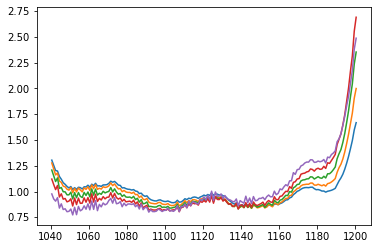

In [122]:
QSOlist = QSOlist_parallel

lmin = 3600
lmax = 5800
ltemp = (lmin + np.arange(2) * (lmax - lmin))

QSO.get_mcont = interp1d(ltemp, 1 + np.zeros(2), fill_value="extrapolate")
QSO.get_eta = interp1d(ltemp, 1+ np.zeros(2), fill_value="extrapolate" )
QSO.get_sigma = interp1d(ltemp, 1+ np.zeros(2), fill_value="extrapolate" )
QSO.get_epsilon = interp1d(ltemp, 1+ np.zeros(2), fill_value="extrapolate" )

for i in range(5):  # num of minimizing iterations
   print('Iteration '+str(i)+' of 5.')
   
   numbers = np.arange(0, len(QSOlist))
   
   QSOlist = recalcDeltas( QSOlist) 
   
   llcont, mcont, wcont = calcMeanCont(QSOlist) 
   print('Mean continuum calculated')
   newcont = QSO.get_mcont(llcont) * mcont
   QSO.get_mcont = interp1d(llcont, newcont, fill_value="extrapolate")
   
   if i == 0 :
      print('recalc first approx' )
      QSOlist = recalcDeltas( QSOlist) 
   
   
   (ll, eta, sigma, epsilon, num_pixels, var_pipe_values,
                    var_delta, var2_delta, count, num_qso, chi2_in_bin, error_eta,
                    error_var_lss, error_epsilon) = minimizeVariances(QSOlist)
   
   w = num_pixels > 0
   get_eta = interp1d(ll[w],
                           eta[w],
                           fill_value="extrapolate",
                           kind="nearest")
   get_sigma = interp1d(ll[w],
                           sigma[w],
                           fill_value="extrapolate",
                           kind="nearest")
   get_epsilon = interp1d(ll[w],
                           epsilon[w],
                           fill_value="extrapolate",
                           kind="nearest")
   
   QSO.get_eta = get_eta
   QSO.get_sigma = get_sigma
   QSO.get_epsilon = get_epsilon
   
   plt.plot( llcont , QSO.get_mcont( llcont ) )

QSOlist = recalcDeltas( QSOlist) 
   
print('done')


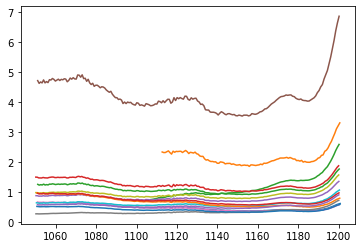

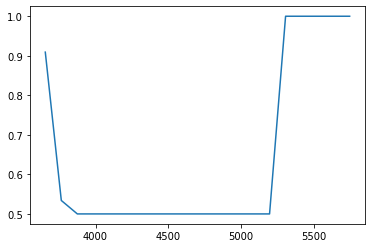

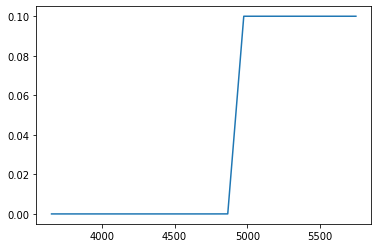

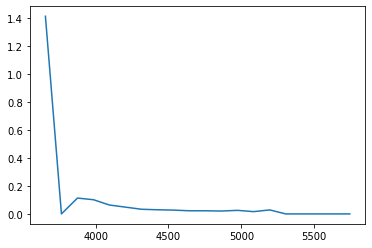

In [233]:

for i in range( 45,60 ):
   plt.plot( QSOlist[i].w, QSOlist[i].delta.cont )
plt.show()

plt.plot(ll,eta)
plt.show()
plt.plot(ll,sigma)
plt.show()
plt.plot(ll,epsilon)
plt.show()

Filename: /work/sfbeltranv/output/log/delta_attributes.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  STACK         1 BinTableHDU     18   614R x 3C   [D, D, D]   
  2  WEIGHT        1 BinTableHDU     19   20R x 5C   [D, D, D, D, D]   
  3  CONT          1 BinTableHDU     15   208R x 3C   [D, D, D]   
  4  VAR           1 BinTableHDU     21   20R x 6C   [100D, 100D, 100D, 100D, 100D, D]   
None
XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   24 / width of table in bytes                        
NAXIS2  =                  614 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one 

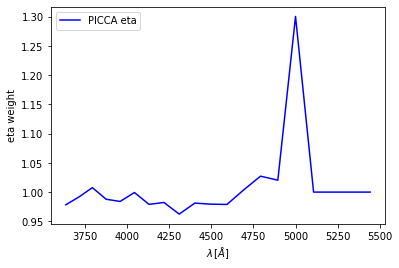

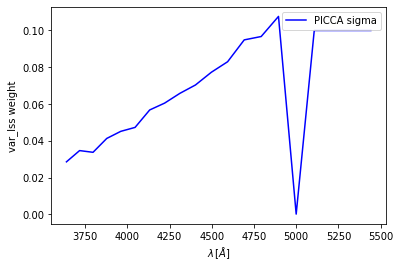

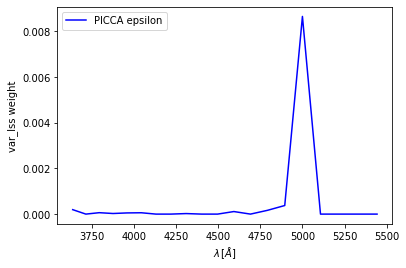

In [150]:
dir1 = '/work/sfbeltranv/output/log/delta_attributes.fits.gz'

cfit1 = pyfits.open( dir1 ,  mode='readonly')     # mode: 'readonly' or 'update'

print( cfit1.info() )
print( repr( cfit1[1].header ) )
print( repr( cfit1[2].header ) )
print( repr( cfit1[3].header ) )
print( repr( cfit1[4].header ) )



plt.plot( 10**cfit1[2].data['loglam'], cfit1[2].data['eta'], 'b', label='PICCA eta'  )

plt.xlabel(r'$\lambda\, [\AA]$')
plt.ylabel('eta weight')
plt.legend()
plt.show()

plt.figure()
plt.plot( 10**cfit1[2].data['loglam'], cfit1[2].data['var_lss'], 'b', label='PICCA sigma'  )

plt.xlabel(r'$\lambda\, [\AA]$')
plt.ylabel('var_lss weight')
plt.legend()
plt.show()

plt.figure()
plt.plot( 10**cfit1[2].data['loglam'], cfit1[2].data['fudge'], 'b', label='PICCA epsilon'  )

plt.xlabel(r'$\lambda\, [\AA]$')
plt.ylabel('var_lss weight')
plt.legend()
plt.show()

cfit1.close()


In [142]:
ra  = np.array( [ QSOlist[i].ra for i in range( len(QSOlist) ) ]  )


7485